# Plotting RSS minima distributions

In [1]:
from ase.io import read, write
from ase.build import bulk
from quippy.potential import Potential
import os
from os.path import join
import numpy as np
from scipy.stats import gaussian_kde
import matplotlib.pyplot as plt
import seaborn as sns

from share.utilities import despine, density_estimation, optimise_structure, RSS

plt.style.use('./share/plot.mplstyle')

# Generate some random intial structures using `buildcell`

note that you must have [buildcell](https://airss-docs.github.io/getting-started/installation/) compiled and on your path for this to work,  
as well as CASTEP itself to use ase's `read_cell` functionality

the plotting example below uses precomputed data, so this step is optional

In [2]:
N = 100
volume = 21
nprocs = 1
buildcell_options = ['NFORM={1,2,3,4,5,6,7,8,9,10,11,12}', 
                     f'VARVOL={volume}',
                     'MINSEP=1.5', 
                     'SYMMOPS=1-4', 
                     'SPECIES=Si%NUM=2', 
                     'VARVOL_RANGE=0.7 1.3', 
                     'COMPACT'
                     'SLACK=0.25', 
                     'OVERLAP=0.1']

tag='Si'
rss = RSS('structures/demo-rss-struc')
rss.buildcells(N, buildcell_options, tag=tag)

Building cells...
Percent: [##############################] 100.00% Done...
Walltime:  0:00:27.040602
Reading cells...

# Optimise structures

After generating initial cells, the next stage of RSS would be to relax them into their local minima.   

We'll do it just for one structure here, because it would take a while to 100 in serial!

In [3]:
from share.utilities import optimise_structure

In [4]:
# assumes you've already downloaded this by running `demo-similarity.ipynb`

GAP18 = Potential(param_filename='potentials/gp_iter6_sparse9k.xml')

In [5]:
relaxed_structure = optimise_structure(rss.init_atoms['Si'][0], potential=GAP18, fmax=0.001)

                Step[ FC]     Time          Energy          fmax
*Force-consistent energies used in optimization.
BFGSLineSearch:    0[  0] 19:35:53     -643.074184*      12.9773
BFGSLineSearch:    1[  1] 19:35:53     -645.623631*       4.3225
BFGSLineSearch:    2[  2] 19:35:53     -645.835087*       1.6737
BFGSLineSearch:    3[  3] 19:35:53     -645.872534*       0.0559
BFGSLineSearch:    4[  4] 19:35:53     -645.872567*       0.0102
BFGSLineSearch:    5[  5] 19:35:53     -645.872568*       0.0000


# Plot the distribution of minima

we will use the data that went into Fig. 8a of the paper

In [ ]:
!tar -xzf structures/GAP-18_RSS.tar.gz

In [6]:
rss_structures = read('structures/GAP-18_RSS.xyz', index=':')

In [7]:
gap18 = Potential(param_filename='potentials/gp_iter6_sparse9k.xml')

use a diamond reference structure for the energy scale

In [8]:
dia = bulk('Si', cubic=True)
dia_opt = optimise_structure(dia, gap18, fmax=1e-4)
dia_opt.calc = gap18

dia_e = dia_opt.get_potential_energy()/len(dia_opt)

                Step[ FC]     Time          Energy          fmax
*Force-consistent energies used in optimization.
BFGSLineSearch:    0[  0] 15:36:57    -1305.407858*       1.5584
BFGSLineSearch:    1[  2] 15:36:58    -1305.419302*       0.5606
BFGSLineSearch:    2[  3] 15:36:58    -1305.421037*       0.0114
BFGSLineSearch:    3[  4] 15:36:58    -1305.421038*       0.0001


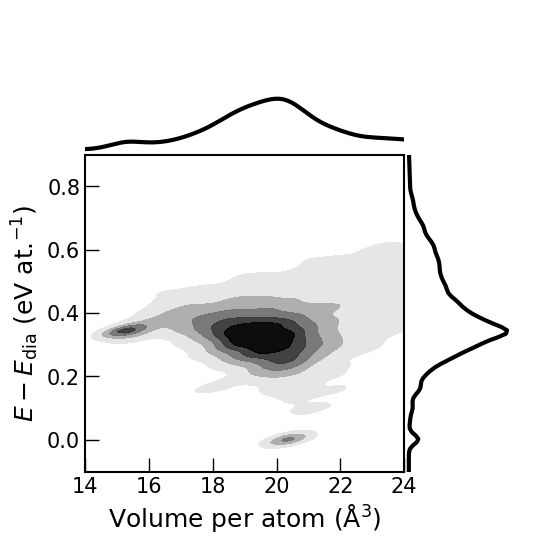

In [42]:
fig, axs = plt.subplots(2,2, figsize=(6, 6), dpi=100,
                        gridspec_kw={'width_ratios':[1,0.45], 'wspace':0.01,
                                     'height_ratios':[0.45,1.0], 'hspace':0.01},
                                      sharey='row', sharex='col')
axs = axs.flatten()
despine(axs[0])
despine(axs[3])

ls = np.array([len(i) for i in rss_structures])
# energies
y = np.array([i.info['energy'] for i in rss_structures])/ls - dia_e
# volumes
x = np.array([i.get_volume() for i in rss_structures])/ls

# Calculate the point density for the countour plot
xmin = x.min()-2; xmax = x.max()+2
ymin = y.min()-0.1; ymax = y.max()+0.2
X, Y, Z = density_estimation(x, y, 
                            xmin, xmax, ymin, ymax, 
                            bw=0.1, point_density=200j)

cmap_i = sns.light_palette('k', as_cmap=True)
axs[2].contourf(X, Y, Z, 
            colors=[np.array(cmap_i(i/4))*0.95 for i in range(5)],
            levels=(np.linspace(0.065, 0.7, 5)),
            extend='max')

# Calculate the kernel density estimate for the marginal plots
kdey = gaussian_kde(y, bw_method=0.1)
zy = kdey.evaluate((zes := np.linspace(-0.2,3.0, 300)))
axs[3].plot(zy, zes, color='k', zorder=0.5)

kdex = gaussian_kde(x, bw_method=0.1)
zx = kdex.evaluate((zvs := np.linspace(3,42, 300)))
axs[0].plot(zvs, zx, color='k', zorder=0.5)

# Plotting limits and labels
axs[2].set(ylim=(-0.1, 0.9), xlim=(14,24),
                xlabel='Volume per atom $(\mathrm{\AA^{3}})$', 
                ylabel=r'$E - E_{\mathrm{dia}}$ (eV at.$^{-1}$)')
axs[3].set(xlim=(-0.1,6))
axs[0].set(ylim=(-0.01,0.5))

axs[1].axis('off')
axs[0].tick_params(bottom = False, left=False)
axs[3].tick_params(bottom = False, left=False)
axs[0].set_yticklabels([])
axs[3].set_xticklabels([])


fig.savefig('images/Si_RSS_plot_fig8.pdf', bbox_inches='tight')